# Detecting Credit Card Fraud
### Ben Griffith, Colby Degan, Nick Neubecker, Ethan Fremder

## Abstract: 

The goal of this project was to create a model that could accurately predict whether a given purchase was fraudulent or not. We got our dataset from Kaggle and it contained just under one million data points. Specific features include distance from home, distance from last transaction, ratio to median purchase price, repeat retailer, used chip, used pin number, and fraud. There were about 87,000 fraud purchases and 910,000 nonfraud purchases in our dataset. The Python packages used in this project were.

- Statsmodel.api -> logisitical models
- Scikit.learn -> SVM models and kernels, grid search, model fitting, etc.
- Matplotlib.pyplot -> plot creation and labeling
- Seaborn -> special plots such as pair plots and heatmaps

Initially, we wanted to get a brief look into how the variables were correlated with fraud. This was done by creating a correlation heatmap and ran a logistic regression model using seaborn, pyplot, and statmodel.api for the model and plotting. The correlation heatmap showed that the ratio to median purchase price was the highest correlated with fraud. Both online order and distance from home also had a notable correlation with fraud. The logistic regression results were not as helpful as we had hoped they would be as although the aforementioned variables had higher correlation than the rest of the features, none exceeded an psuedo R-squared value of 0.5. The logistic model did not even let us trim away uneeded variables as they all had P values under 0.005 and were considered statistically significant. Given this, there were better models to use to classify multivariant binary data like ours, so we moved away from the logistical model and statmodel.api.

This caused our focus to shift to Support Vector Machines (SVMs), which we considered to be a good fit for our project. However, after using the seaborn pairplot function to see if even a subset of the data was linearly separable, we realized that we needed a method to would allow us to account for two issues. One was that higher dimensions beyond the 7 features from our dataset were needed to model this data and make it separable. Two, we needed to split the data more evenly between fraudulent purchases and non-fraud purchases to account for the heavy bias toward non-fraud present in the dataset and the majority of randomly sampled subsets. Removing the bias from the sampled data was done by masking the data frames into two frames, one with all fraud and one with no fraud. These were then both randomly sampled for 25,000 samples and concatenated together. The higher dimension issue was by switching the SVM kernel from poly to rbf. Leveraging some code learned from class we implemented the sklearn grid search function to find the optimal pair of C and gamma for our SVM model.

The optimal form of the SVM model had around 98% accuracy which varied by at worst 1.5% depending on the sampling of the data. This was true when tested on a testing set of data AND when testing on the entire original dataset. The error also shifted from the earlier SVMs where most of the error was false negatives, not predicting fraud when there was fraud, to false positives, where fraud was predicted on a non-fraudulent transaction. In the test the SVM did on the entire dataset, assuming the model predicted a transaction as fraudulent, there was about a 16% chance that the purchase was not fraudulent. It could be argued that this means the model became biased toward predicting fraud, we argue that for credit like credit cards, letting fraud go is more dangerous than being overly cautious.

When it came to creating a function to allow users to input their own transaction data to predict fraud with. We were able to get the function working; however, there were limitations to it. The main limitation is that the data must be of the same feature size and labeling as the original format, meaning that missing data is not allowed. If there were time, we wanted to try to use PCAs in order to create several SVMs for various cases of missing data and then have the model work with varying reported accuracies for any combination of inputted features. 

## Finding the Data:

The initial search of the data was done using kaggle.com, primarly looking for .csv file due to the ease of using them. There was some difficulty with datasets not containing the names of the features of the dataset and some datasets not containing labels of whether or not a given purchase was fraudulent or not. While this technically would not be an issue for the group creating a model, it is an issue when it comes to explaining the context of the model. After a short search, the group found this dataset [here](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud). This dataset, while not having as many features as some of the non-labeled files, contained names for each feature and a column that confirmed whether or not results were fraudlent Some further searching was done afterward, but the linked dataset was decided to be the best for the project goal of being able to create to properly model and predict fraud with user given data.

## Methods Used: 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
# load in methods and packages

## Reading the Data: 

Below is the initial code used to read the data, which mainly gave the group information that was visible back on kaggle.com. The description of each feature name and what they mean is:

 - distance_from_home: The distance the transaction was away from the owner's home, unit -> assumed to be miles or kilometers.
 
 - distnace_from_last_transaction: The distance the transaction was from the owner's last known transaction, unit -> assumed to be miles or kilometers.
 
 - ratio_to_median_purhcase_price: The ration of the transaction to the median of the owner's purhcases on that credit card, unitless -> transaction price:median price -> X:1.
 
 - repeat_retailer: Was the transaction from a retialer previously purchased from by the owner, unit -> binary classification (1 = True, 0 = False)
 
 - used_chip: Was the chip on the card used to conduct the purchase, unit -> binary classification (1 = True, 0 = False)
 
 - used_pin_numer: Was the pin number of the user inputted during the purchase, unit -> binary classification (1 = True, 0 = False)
 
 - online_order: Was the transcation done digitally using an online store or website, unit -> binary classification (1 = True, 0 = False)
 
These are each of the featuers and the label is:

 - fraud: Was the transaction fraudelent or not, unit -> binary classification (1 = True, 0 = False)
 
When looking at the size of the dataset, this constitutes a 7th dimensional dataset with exactly 1,000,000 data entries, and from later code it will be seen that this data has been pre-curated to inlcude no missing or corrupted data. This is more than enough data to create a classification model to determine credit card fraud using the tools learned in class.

In [2]:
#load in the dataset and show it
cc_data = pd.read_csv('card_transdata.csv')
cc_data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Approach 1 - Logistical Models:

An initial approach to creating a model that would determine if a purchase is fraud or not was to run a logistic regression. The reasoning behind this is that logistic models have two outputs. It is either this or that which is the exact case we are dealing with in this project. It is either fraud or it is not fraud. When modleing the logistic regression, we broke the data up into features and labels where features were all variables except fraud and labels were the fraud variable. 

### Making the Model and Determining Correlation:

In [3]:
#train and test features to put into a logistic model
features = pd.DataFrame(cc_data[['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price','repeat_retailer','used_chip','used_pin_number','online_order']])
labels = pd.Series(cc_data['fraud'])
train_feat, test_feat, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, random_state = 0)

In [4]:
#create the model and show the results
logist_model = sm.Logit(train_labels, sm.add_constant(train_feat))
result = logist_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.135986
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fraud   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799992
Method:                           MLE   Df Model:                            7
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:                  0.5418
Time:                        20:30:31   Log-Likelihood:            -1.0879e+05
converged:                       True   LL-Null:                   -2.3741e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.3525      0.049   -212.091      0.000     -10.448     -10.257
distance_from_home                 0.0153   9.34e-05    163.633      0.000       0.015       0.015
distance_from_last_transaction     0.0249      0.000     93.441      0.000       0.024       0.025
ratio_to_median_purchase_price     0.8607      0.003    271.677      0.000       0.855       0.867
repeat_retailer                   -0.6183      0.018    -35.073      0.000      -0.653      -0.584
used_chip                         -1.0432      0.014    -76.450      0.000      -1.070      -1.016
used_pin_number                  -13.4819      0.175    -77.172      0.000     -13.824     -13.140
online_order                       6.6449      0.042    159.752      0.000       6.563       6.726
==================================================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

The results from the model were not as good as we hoped. We got a p value of zero for all variables and we got a pseudo R-squared value of 0.5418. This value shows that the model is decent but not as good as we are looking to make it. 

We then looked into the correlation between variables. We figured we could find some strong correlations that would launch us into the next step of the project. 

Text(0.5, 1.0, 'Correlation Heatmap')

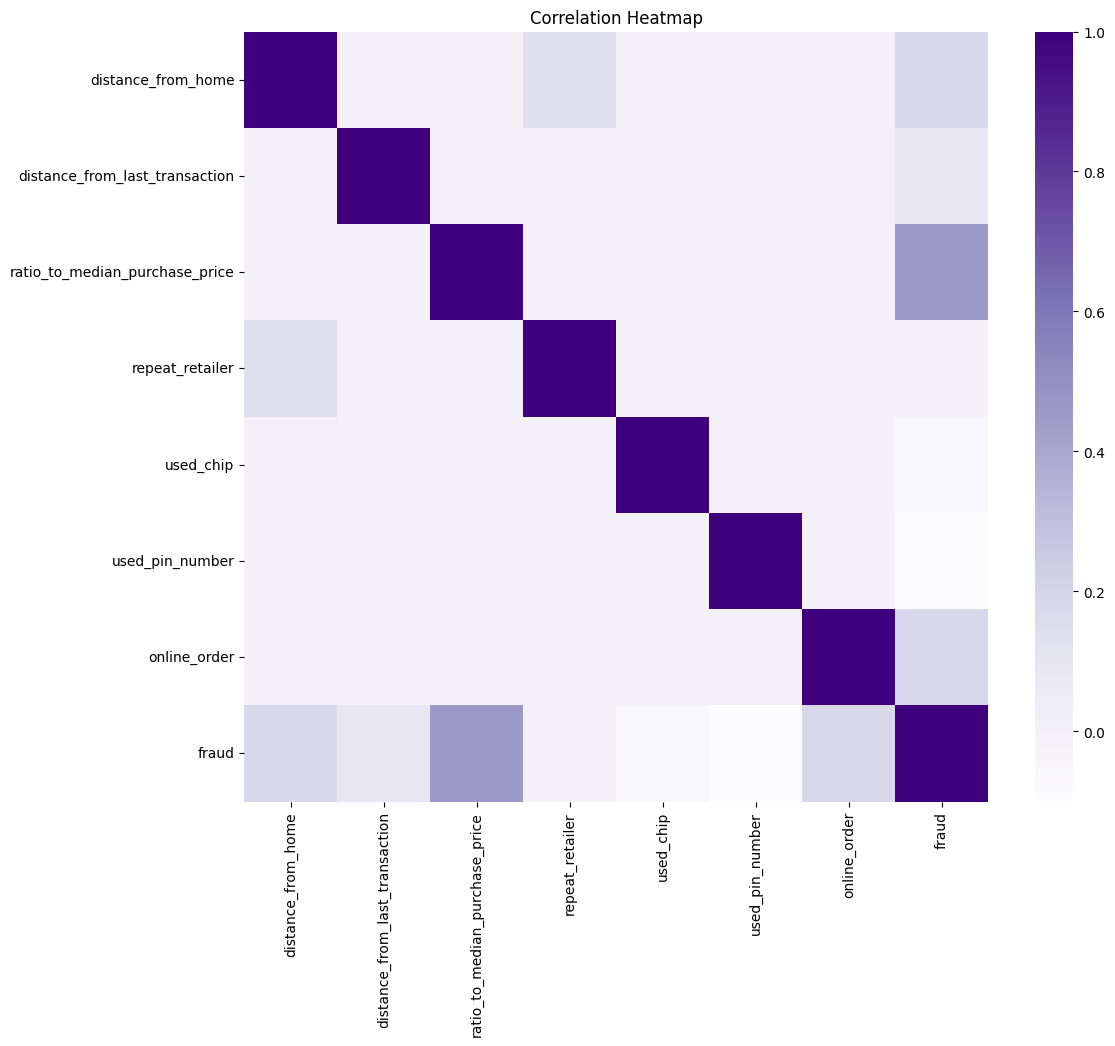

In [5]:
#create a heatmap showing the correlations between variables
ccdata_corr = cc_data.corr()
fig = plt.figure(figsize = (12, 10))
sns.heatmap(ccdata_corr, cmap='Purples')
plt.title('Correlation Heatmap')

We found that the strongest correlation to fraud was ratio_to_median_purchase_price. Other notable variables include distance_from_home and online_order

### Looking into the Highest Correlated Variable:

We wanted to dive a little deeper into the ratio_to_median_purchase_price as it was the highest correlated with fraud. Even though it was the highest correlated, there still is not enough of a relationship between fraud and ratio to median purchase price which leads us into the next part of the project, multivariate analysis. Since our data is a binary classification, there are better models than a logistic regression model to predict fraud. 

In [6]:
#because ratio to median purchase price has the highest correlation
#create a jitter for the x values so it is not as clumped
data_jit_x = []
for i in range(len(cc_data)):
    jitter = random.uniform(-15,15)
    data_jit_x.append(jitter)

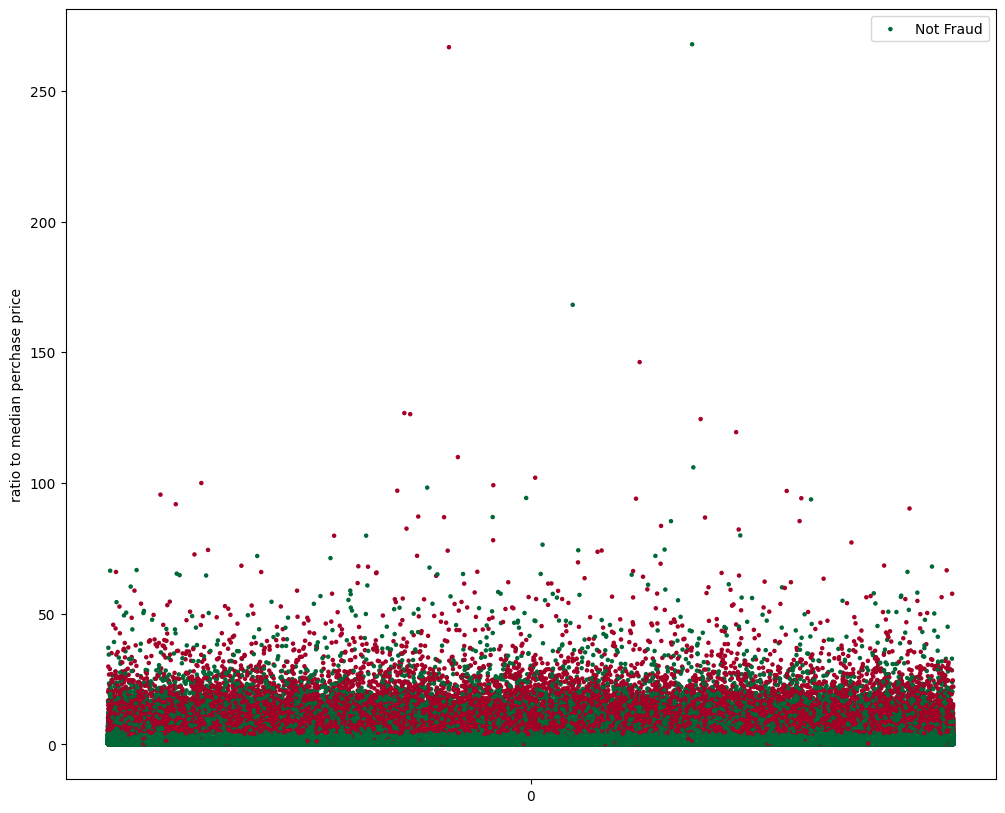

In [7]:
#create a scatter plot
fig = plt.figure(figsize = (12, 10))
plt.scatter(data_jit_x,cc_data['ratio_to_median_purchase_price'],c=cc_data['fraud'],s=5,cmap='RdYlGn_r')
plt.ylabel('ratio to median perchase price')
plt.xticks([0])
plt.legend(['Not Fraud'])

## Approach 2 - Support Vector Machines (SVMs):

Since logistical models did not give the best results when it came to classifying the data in the model, the group decided to lean into a newer method of classification model from class. SVMs were seen a perfect for this kind of dataset and goal as a well made SVM would easily be able to predict fraud with adjustable margins as to how strict or not the group wanted the determining line of fraud or not to be.

Overall, SVMs allowed the group to take advantage of an extremely powerful modeling type with two main restrictions. One is that a classification model will only be proficient at classifying descrete data results; however, this first concern was a non-issue as the label of this data is a binary outcome. A purchase is either fraudelent or not, there is not in between. However, the other restiction was more of a concern.

### Sampling the Data - Is it Linearly Seperable?:

The second restriction of SVMs is one it shares with perceptrons. That is, the data must be linearly seperable in order for a seperating object to classify the data, for SVMs this geometric object is class the hyperplane of the decision boundary.

However, in oder to display the results and judge whether or not they were linearly seperable, the data must be plotted. CMSE 202 students are taught many plotting methods for 2D and 3D data and higher order data tends to be plot. However, given the 7 features in this dataset, plotting all the data at once is not possible. As such, the seaborn pairplot function was called upon to plot each feature againt each other. The idea behind plotting the data in such a way was that if two features alone were not linearly seperable when plotted together, then they most likely would not when plotted with other variables.

Another action that was taken here was to only plot a random sample of 50,000 (5%) of the original dataset. This was done here and in the remainder of the code due to the restrictions of many of these Python libaries with large datasets. 5% of the data was seen as a good balance of still being able to capture a suitable sample of the data while not overloading the functions and making the code runtime too long. As for the linearly seperable portion and how using a sample here deviates from using the whole dataset, well if a sample is not seperable, then the entire dataset cannot be.

From the pairplot it became clear that at least when plotted in a series of 2D plots, the data was not seperable from one another. However, it was still decided to try out using some basic SVMs on this unmodified data anyway.


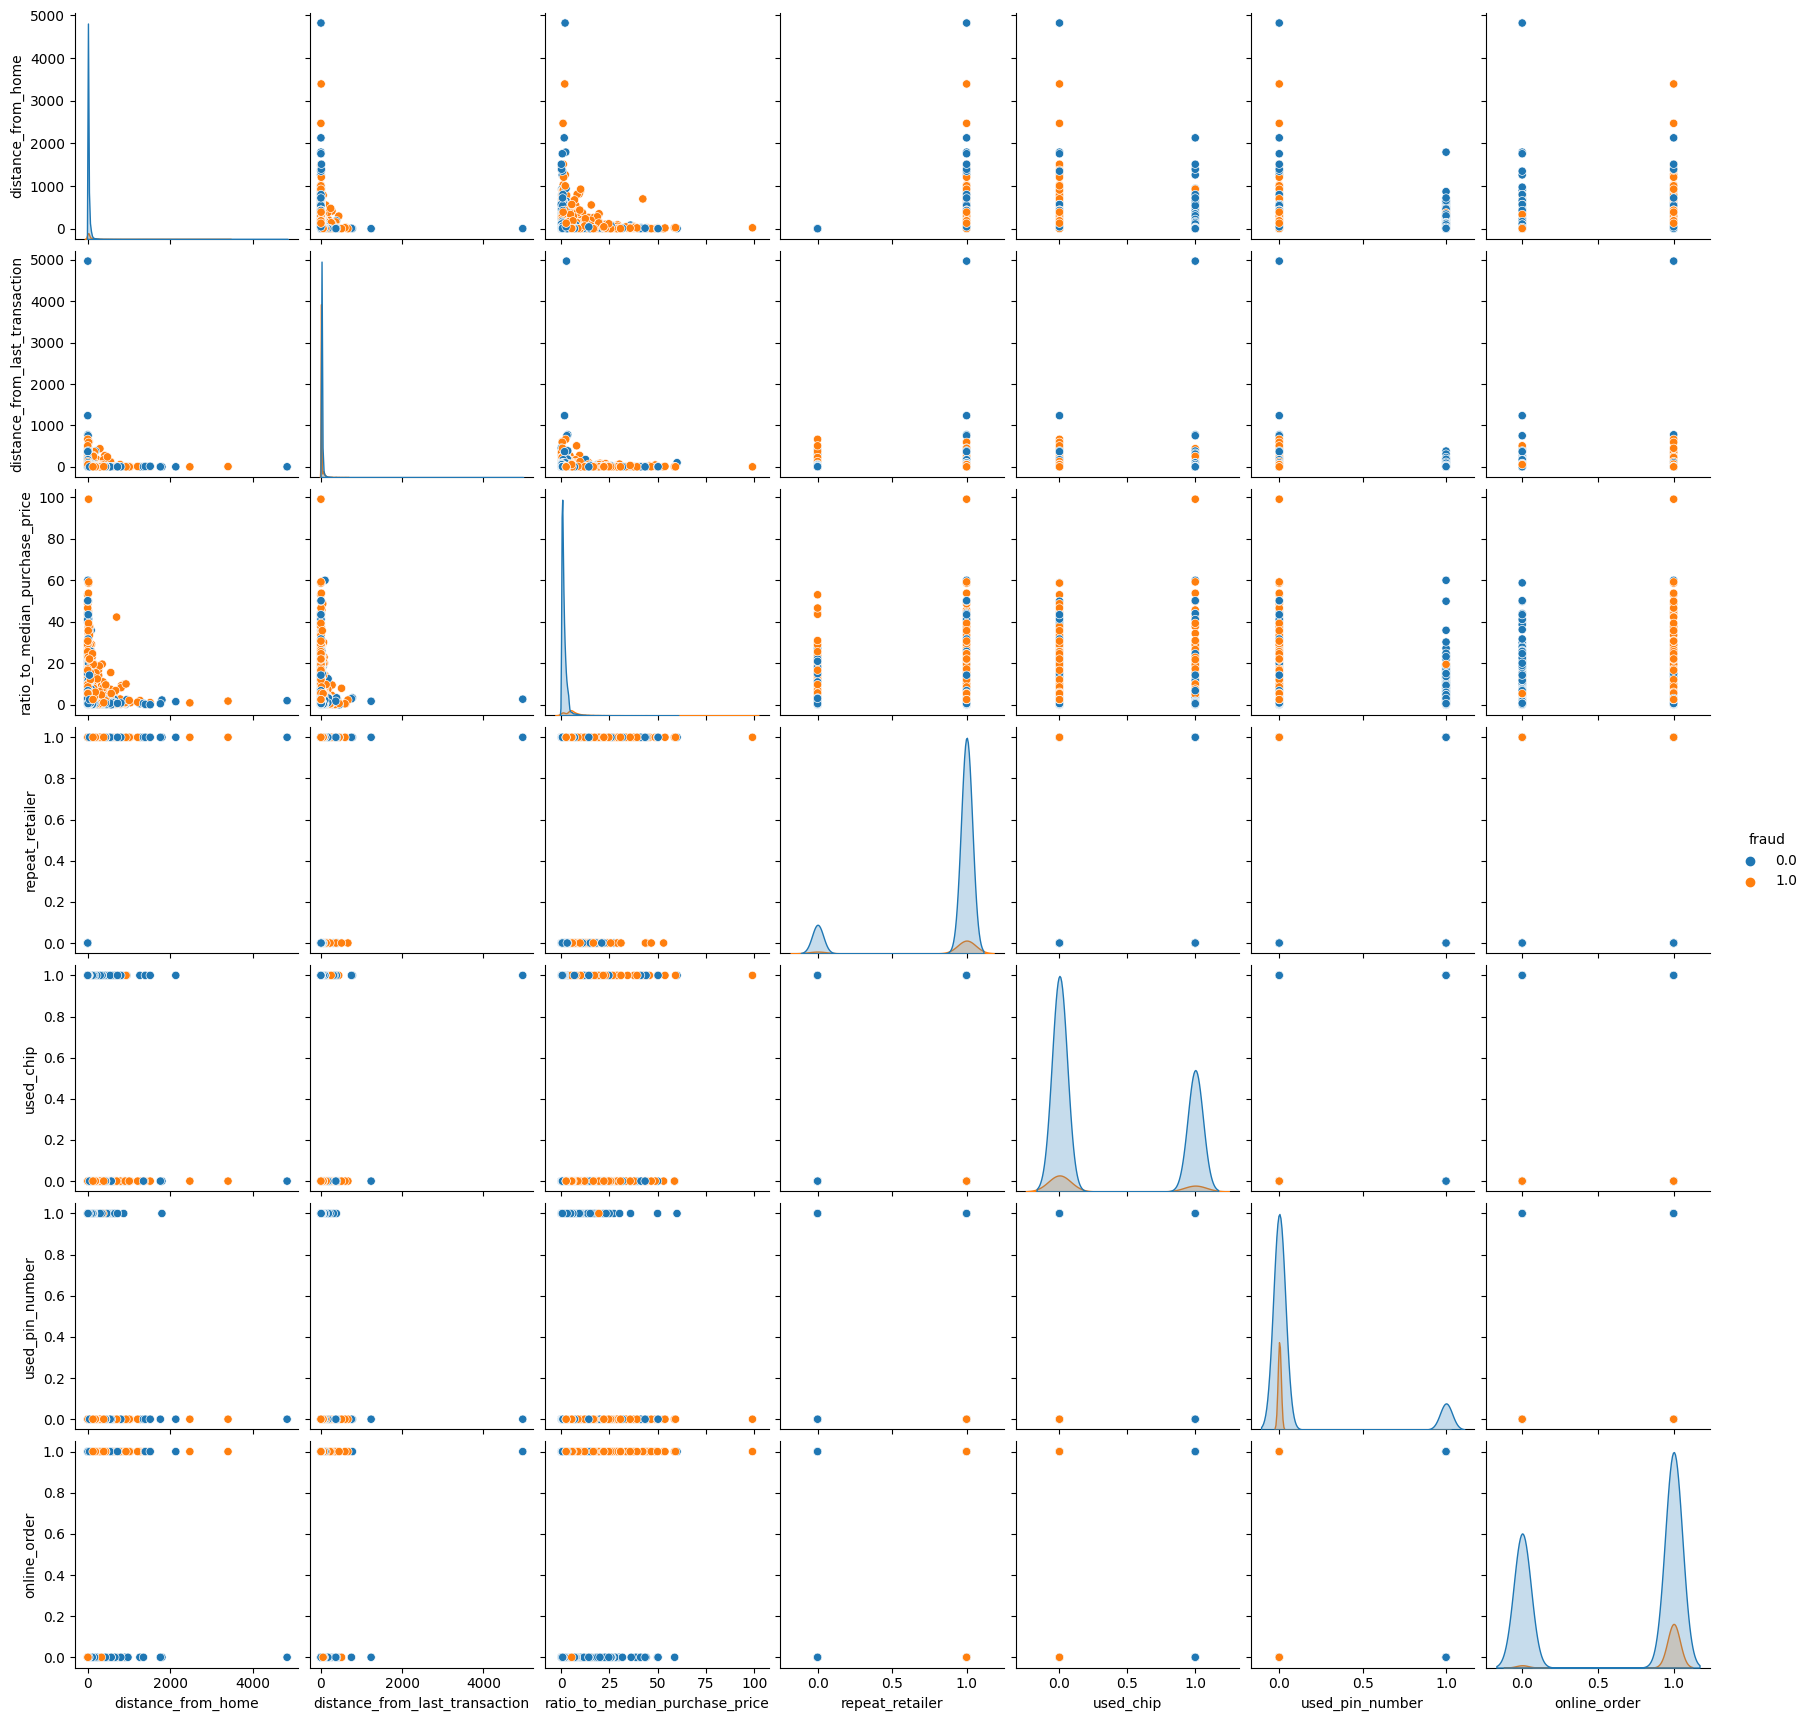

In [8]:
# take a sample of the data and create a 7 feature pairplot
# to show whether or not the data is linearly seperable
cc_sample = cc_data.sample(n=50000)
sns.pairplot(cc_sample, hue = 'fraud')
# 7 feature SVM

### Testing Basic SVMs Regardless: 

Since from the pairplots the credit card fraud data was not linearly seperable, creating an SVM using this non-seperable data was going to have limited success as a model. However, the group wanted to do so anyway as a proof of concept of sorts. Creating a few SVMs with varying strictness in the margins with C values would be a good way to show that there were steps that needed to be taken to improve the model.

The below code blocks show the seperation of the sampled data into training and testing sets and tried with various SVM models with different C values ranging from C = 100 to C = 0.1. These were all done using the poly kernel of the SVM funciton from sklearn, mainly based on the intuition of the group when looking at the data in the pairplots.

Overall, these SVMs were abject failures, as expected. However, the reason as to the failure actually came from a few sources. The first source was the most obvious in that 7 features that have non-linearly seperable data are not enough to properly make a classification model from due to not capturing enough dimensions to properly creat a hyperplane that can seperate the data. 

The next issue was an oversampling issue. Most credit card purchases are not fraud, and therefore the amount of data in the set and most random samples of the set will have far more non-fraud purchases than fraud purchases. This trains the SVM model to bias classifying data as not being fraud. Looking at the SVM heatmaps made from the confusion matrices using seaborn and sklearn respectively, it can be seen that the C value basically has no effect at all on the SVM classification model due to how overly biased the data is. It looks like the model is actually accurate to a degree because it accurate predicts that most of the sampled data is True False (Predicted non-fraud and actually non-fraud). However, looking at the other categories it can be seen that the model has basically just memorized that most data except for a few exceptions indicates no fraud. The proof for this can be seen in that every SVM, regardless of C value, has more false negatives than true positives, meaning that the model assumes more purchases are not fraud when they should be.

In [9]:
features = cc_sample.iloc[:,:-1] # grab all columns, but final column
labels = cc_sample.iloc[:,-1] # grab final column

train_fet, test_fet, train_lab, test_lab = train_test_split(features, labels, 
                                                            train_size = 0.7)
# split the data into training and testing sets

The accuracy of this model is: 0.9342
Note the that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,13648,44
Actual Fraud,943,365


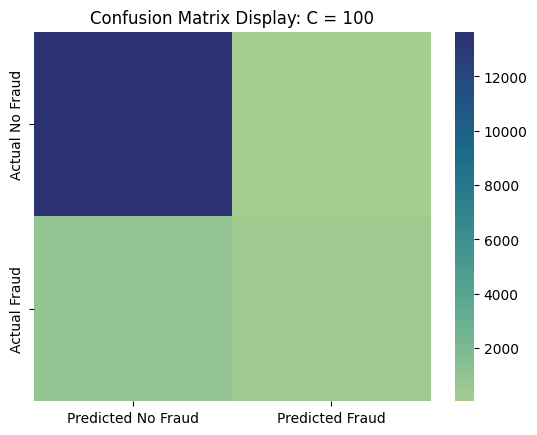

In [10]:
poly = svm.SVC(C = 100, kernel = 'poly')
fit_poly1 = poly.fit(train_fet, train_lab)
# create and fit SVM

poly1_pred = fit_poly1.predict(test_fet)
poly1_con = confusion_matrix(test_lab, poly1_pred)
poly1_con = pd.DataFrame(poly1_con, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])
# predict values with SVM and place results in a confusion matrix

#print the accuracy
accuracy = accuracy_score(test_lab, poly1_pred)
print('The accuracy of this model is:',accuracy)

sns.heatmap(poly1_con, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 100")
# display a heatmap of the confusion matrix

print('Note the that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
poly1_con # numeric confusion matrix

The accuracy of this model is: 0.9299333333333333
Note the that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,13666,26
Actual Fraud,1025,283


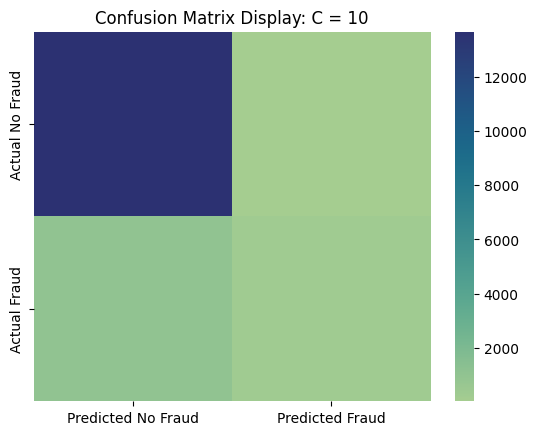

In [11]:
poly = svm.SVC(C = 10, kernel = 'poly')
fit_poly2 = poly.fit(train_fet, train_lab)
# create and fit SVM

poly2_pred = fit_poly2.predict(test_fet)
poly2_con = confusion_matrix(test_lab, poly2_pred)
poly2_con = pd.DataFrame(poly2_con, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])
# predict values with SVM and place results in a confusion matrix

#print the accuracy
accuracy = accuracy_score(test_lab, poly2_pred)
print('The accuracy of this model is:',accuracy)

sns.heatmap(poly2_con, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 10")
# display a heatmap of the confusion matrix

print('Note the that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
poly2_con # numeric confusion matrix

The accuracy of this model is: 0.9239333333333334
Note the that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,13680,12
Actual Fraud,1129,179


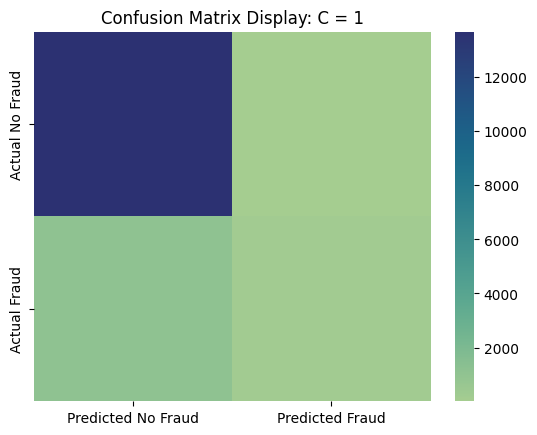

In [12]:
poly = svm.SVC(C = 1, kernel = 'poly')
fit_poly3 = poly.fit(train_fet, train_lab)
# create and fit SVM

poly3_pred = fit_poly3.predict(test_fet)
poly3_con = confusion_matrix(test_lab, poly3_pred)
poly3_con = pd.DataFrame(poly3_con, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])
# predict values with SVM and place results in a confusion matrix

#print the accuracy
accuracy = accuracy_score(test_lab, poly3_pred)
print('The accuracy of this model is:',accuracy)

sns.heatmap(poly3_con, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 1")
# display a heatmap of the confusion matrix

print('Note the that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
poly3_con # numeric confusion matrix

The accuracy of this model is: 0.917
Note the that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,13685,7
Actual Fraud,1238,70


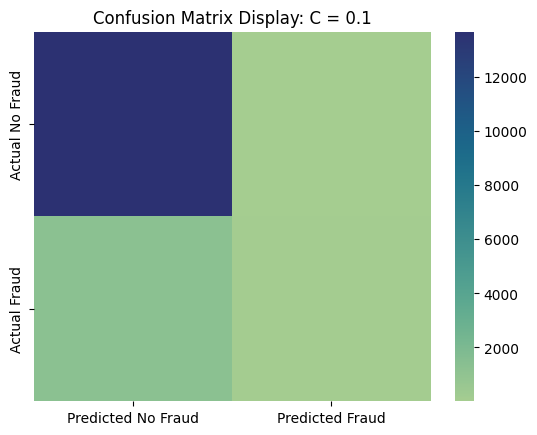

In [13]:
poly = svm.SVC(C = 0.1, kernel = 'poly')
fit_poly4 = poly.fit(train_fet, train_lab)
# create and fit SVM

poly4_pred = fit_poly4.predict(test_fet)
poly4_con = confusion_matrix(test_lab, poly4_pred)
poly4_con = pd.DataFrame(poly4_con, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])
# predict values with SVM and place results in a confusion matrix

#print the accuracy
accuracy = accuracy_score(test_lab, poly4_pred)
print('The accuracy of this model is:',accuracy)

sns.heatmap(poly4_con, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 0.1")
# display a heatmap of the confusion matrix

print('Note the that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
poly4_con # numeric confusion matrix

### Curating Data for Better SVM Models:

These next blocks of code address and show how the data was curated to have an even amount of fraud and non-fraud samples in it. First, all 1,000,000 data points were masked into two pandas dataframes, one for fraud and one for non-fraud. Here it can be seen that less than 10% of the data was purhcases that were fraudulent and over 90% were non-fraudelent. 

Then a random sample of 25,000 was taken of each subset of the data and concatenated together to create a dataset with 50,000 samples like previously, but this time with equal amounts of fraud and non-fraud. From the .head() and .tail() functions it can be seen that the concatenation did not mix up the two 25k subsets. However, since the new dataset will be split into training and testing data randomly anyway, it does not matter.

In [14]:
#split the data into fraud and not fraud
fraud = cc_data[cc_data['fraud']==1]
not_fraud = cc_data[cc_data['fraud']==0]

print('There are',len(fraud),'purhcases in the dataset that are fraud.')
print('There are',len(not_fraud),'purhcases in the dataset that are not fraud.')

There are 87403 purhcases in the dataset that are fraud.
There are 912597 purhcases in the dataset that are not fraud.


In [15]:
#take a random sample of 25,000 each
fraud25k = fraud.sample(25000)
notfraud25k = not_fraud.sample(25000)

ccdata25k = pd.concat([fraud25k,notfraud25k])

In [16]:
ccdata25k.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
149584,17.997038,4.433807,4.151599,1.0,1.0,0.0,1.0,1.0
165749,1.505317,0.013585,6.043903,0.0,1.0,0.0,1.0,1.0
891425,99.953961,0.790132,5.906660,1.0,1.0,0.0,1.0,1.0
153879,107.581773,4.132989,3.564304,1.0,0.0,0.0,1.0,1.0
204031,65.171848,11.773948,12.891969,1.0,1.0,0.0,1.0,1.0


In [17]:
ccdata25k.tail()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
474101,2.464254,0.630904,1.173648,1.0,0.0,0.0,1.0,0.0
608222,2.172758,0.024613,0.390429,1.0,0.0,0.0,1.0,0.0
706492,31.188267,0.609728,1.082331,1.0,1.0,0.0,1.0,0.0
750737,2.477307,2.630115,0.544021,1.0,1.0,0.0,1.0,0.0
880576,4.113765,15.646348,4.683035,1.0,0.0,0.0,0.0,0.0


### SVMs with Curated Data -> Switching from Poly to RBF Kernel:

With the data now curated so that it will not be overly biased toward non-fraud, the next step was to change the SVM to place the data into higher dimensions so that the lack of linear seperability would no longer be an issue. While a traditional method of doing this would be finding mathematical transformations for the 7 features in the dataset, class assignments actually showed the group a more efficient way to approach this issue.

The RBF kernel of the sklearn SVC/SVM function uses a mathematical equation to calculate similarity between points in a dataset and then uses the similarity to determine a 'transformation' that will better seperate the data. Much like the C value determine the strictness of the SVM boundaries, the RBF kernel can be tuned using a gamma value. 

The below code cell creates and trains an SVM using the RBF kernel with a test C value from the earlier SVMs that used the poly kernel and a gamma value based on what was used in class when the RBF kernel was taught. The results were actually much better than expected. Between the more balanced data distribution and the new kernel, the prediction shot up to around 96% accuracy with a margin of around 1.5% from repeated tests with random samples.

Another thing to note is the large shift away from false negative into more false postives and true positive, which will be discussed further with the optimal model results and the results section.

The accuracy of this model is: 0.9606666666666667
Note that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,6993,542
Actual Fraud,48,7417


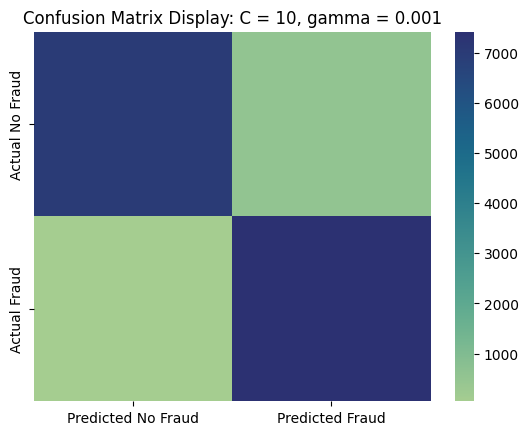

In [18]:
#split into train and testing
features = ccdata25k.iloc[:,:-1]
labels = ccdata25k.iloc[:,-1]

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                            train_size = 0.7)

#run the svm
svm = SVC(C=10,kernel='rbf',gamma = 0.001)
rbf_fit = svm.fit(train_features, train_labels)
prediction = rbf_fit.predict(test_features)

#print the accuracy
accuracy = accuracy_score(test_labels, prediction)
print('The accuracy of this model is:',accuracy)

#show the confusion matrix and heatmap
con_matrix = confusion_matrix(test_labels, prediction)
con_matrix = pd.DataFrame(con_matrix, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])

sns.heatmap(con_matrix, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 10, gamma = 0.001")

print('Note that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
con_matrix

### Grid Search - Finding Optimal C and Gamma Values:

Now, learning to use RBF is not the only thing that the group learned about to better the model. Part of making the best model possible is tuning it, and the class assignment where RBF was learned about also included a method from sklearn to help tune the RBF parameters of C and gamma to an optimal pair of given values. This is called `grid_search`. 

This method essentially trains various SVMs using a combination of parameters and kernels given to it in a parameter grid and then finds which kernel and parameter pairing results in the best model. Of course, the time to calculate this varies with the parameter combinations given in the grid. However, the group wwanted to stick to a simple set of C and gamma ranges and see the results from that.

From the grid search, it was found that using the RBF kernel, the best C and gamma pair was `C = 100` and `gamma = 0.005`.

In [19]:
#our parameter grid
param_grid = {'C': [0.1, 1.0, 10.0, 100.0],
              'gamma': [0.0001,0.0005,0.001,0.005,0.01,0.05],
              'kernel': ['rbf']}
svc = SVC()

#search for the best parameters
grid_search = GridSearchCV(svc, param_grid)
grid_search.fit(train_features,train_labels)

best_params = grid_search.best_params_
best_params

{'C': 100.0, 'gamma': 0.005, 'kernel': 'rbf'}

### Re-Test Results on Original Data:

Now that the best C and gamma pair has been found, the group wanted to apply them to a RBF kernel SVM. They did so and compared the resutls using confusion matrices and classification reports. The the SVM was tested against two sets of data. The first set was the testing set and labels of the 50,000 sample set with 25,000 cases of fraud and 25,000 cases of non-fraud. The second set of data was the entire original dataset with all 1,000,000 data points to see how accurately it could predict results in a non-evenly divided dataset of fraud and not fraud.

These two test revealed some interesting information about the model now as to its quality and how it would be used in the real world. This will be expanded upon in the results and conclusion section, but the overall accuracy of the model was around 98% with both the testing set and the entire dataset with a bit over a percentage of variance with different random samples and training/test splits. However, despite the accuracy increase, the places of error shifted from a majority of error being false negative to being false postive for fraud, which has interesting implications for the real world.

The classification report of the data is: 
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      7535
         1.0       0.98      0.99      0.99      7465

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000

Note that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,7364,171
Actual Fraud,50,7415


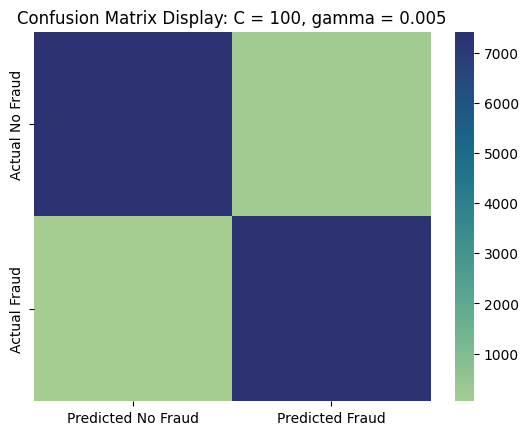

In [23]:
#run the svm with the best parameters
svm = SVC(C=100,kernel='rbf',gamma = 0.005)
optimal_rbf_fit = svm.fit(train_features, train_labels)
prediction = optimal_rbf_fit.predict(test_features)

#print the accuracy
print('The classification report of the data is: ')
print(classification_report(test_labels, prediction))

#show the confusion matrix and heatmap
con_matrix = confusion_matrix(test_labels, prediction)
con_matrix = pd.DataFrame(con_matrix, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])

sns.heatmap(con_matrix, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 100, gamma = 0.005")

print('Note that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
con_matrix

The classification report of the data is: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    912597
         1.0       0.82      1.00      0.90     87403

    accuracy                           0.98   1000000
   macro avg       0.91      0.99      0.94   1000000
weighted avg       0.98      0.98      0.98   1000000

Note that the null hypothesis is that there was no fraud.

Here is the number based matrix:


,Predicted No Fraud,Predicted Fraud
Actual No Fraud,892923,19674
Actual Fraud,420,86983


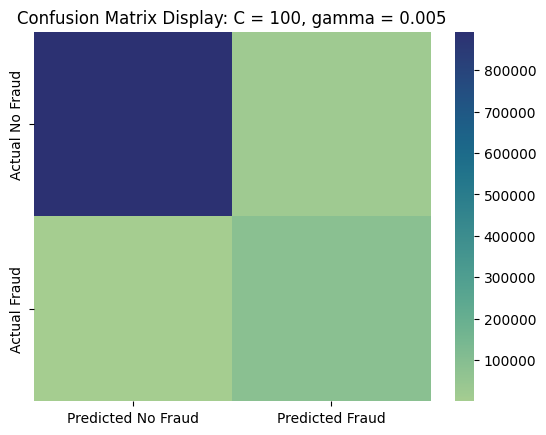

In [24]:
final_feat = cc_data.iloc[:,:-1] # grab all columns, but final column
final_lab = cc_data.iloc[:,-1] # grab final column

final_pred = optimal_rbf_fit.predict(final_feat)

#print the accuracy
print('The classification report of the data is: ')
print(classification_report(final_lab, final_pred))

#show the confusion matrix and heatmap
con_matrix = confusion_matrix(final_lab, final_pred)
con_matrix = pd.DataFrame(con_matrix, columns=['Predicted No Fraud','Predicted Fraud'], 
                         index=['Actual No Fraud','Actual Fraud'])

sns.heatmap(con_matrix, cmap = 'crest')
plt.title("Confusion Matrix Display: C = 100, gamma = 0.005")

print('Note that the null hypothesis is that there was no fraud.')
print()
print('Here is the number based matrix:')
con_matrix

## Making a Function to Predict Fraud with User Inputted Data:

Here the group decided to a make a tool where a user can use the optimal model made to enter custom transaction data to test if a transaction is fraudulent or not. Currently, it requires all 7 features to have data recorded in them and for them to be formatted correctly. A future goal if this project were to contine would be to make multiple models that work with this function so it could predict fraud when missing data. This would come with a cofidence rating of the prediction depending on the model used.

The second half of this code block contains code for randomly generating a transaction in the correct format for the function to use. At the moment, the results of the function don't always match the randomly generated transaction's label because the randomly generated data does not follow the trends established by the datasent. Hence the side by side comparison with a random sample from the dataset.

In [25]:
def cc_fraud_tool(data):
    '''
    This is a function designed to take in a list of formatted
    data about a transaction for this function to check that format
    and output the predict label of whether or not it is fraud.
    
    The goal would be to expand this function to be able to take in non-
    foramtted data as well as lists with missing data. However, a better
    model would be needed for that.
    ________________
    Inputs: Data -> List, numpy array, Pandas data series
    Outputs: The predicted label of the data
    '''
    col = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price',
           'repeat_retailer','used_chip','used_pin_number','online_order']
    data = pd.DataFrame(data = data, columns = col)
    pred = optimal_rbf_fit.predict(data)
    if pred == 1:
        print('The purchase is predicted to be fraudulent.')
    else:
        print('The purchase is not predicted to be fraudulent.')
            
            
# create mock transaction
template_transaction = cc_data.sample(1)

mock_distance_from_home = np.random.uniform(0, 100)  
mock_distance_from_last_transaction = np.random.uniform(0, 100)  

mock_transaction = {
    'distance_from_home': mock_distance_from_home,
    'distance_from_last_transaction': mock_distance_from_last_transaction,
}

for i in cc_data.columns:
    if i not in mock_transaction:
        mock_transaction[i] = template_transaction[i].values[0]
        
mock_values = list(mock_transaction.values())
mock_keys = list(mock_transaction.keys())
mock_data = pd.DataFrame(data = [mock_values], columns = mock_keys)

print('Results with a random sample from the dataset:')
cc_fraud_tool(cc_data.sample(1))
print(cc_data.sample(1))
print()

print('Results with a randomly generated transaction:')
cc_fraud_tool(mock_data.iloc[:,:-1])
print(mock_data)

Results with a random sample from the dataset:
The purchase is not predicted to be fraudulent.
        distance_from_home  distance_from_last_transaction  \
959568            0.954235                        1.472439   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
959568                        0.404794              0.0        1.0   

        used_pin_number  online_order  fraud  
959568              0.0           0.0    0.0  

Results with a randomly generated transaction:
The purchase is predicted to be fraudulent.
   distance_from_home  distance_from_last_transaction  \
0             30.5256                       99.296825   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.247721              1.0        0.0   

   used_pin_number  online_order  fraud  
0              0.0           1.0    0.0  


## Results and Conclusion:

Overall, the group considered this the end SVM with the optimized C and gamma values and the rbf a success. When tested on both the testing data with the curated data that was 50% fraud and 50% non-fraud the overall accuracy of the model was around 98% with some variance based on the random sample and the training and test splits, and the same was true for the same SVM when tested on the original dataset with no sampling or splitting. 

The main sources for the success of the model after the failures of the first ones shown in the update presetation where the curated dataset and the switch of the kernel from poly to rbf. The curated dataset ensured that the model would not be trained with a bias toward data not being fraudulent. As shown in an earlier code block there are 87403 purhcases in the dataset that are fraud and 912597 purhcases in the dataset that are not fraud. That amounts to 8.7% of the data being fraudulent purchases and 91.3% of the data being normal purhcases with no fraud. This is what led to the SVMs in the update presentation having such little variance between C values and false negatives for fraud being so common. The swtich from the poly kernel to the rbf kernel, along with the grid search to find the best C and gamma pairing for the rbf kernel covered the issue of the data not being linearly seperable. The rbf kernel essentially allowed the group to project the features into higher dimensions without having to actually calculate the transformations to do so.

A thing to note however, is that the 50/50 split of fraud and no fraud data for the sample dataset used to train the new SVMs might have actually caused a bias toward false positives, meaning that the model is labeling transactions as fraudulent when they are actually not. In the test of the SVM against the entirety of the dataset, if the SVM predicted a fraudulent purchase, there was a 16.7% chance (give or take a few percent due to sampling) that the model would predict a non-fraudulent purchase as fraud. However, the group decided ultimately that this error was far more acceptable than the false negatives from the earlier SVMs. The reason for this being that a purchase that is flagged as fraudulent when it is not can be hashed out civily between the owner of the credit card and the bank without damage to the card owner, whereas any delays and complications with the reverse error could lead to large amounts of financial damage.

Finally, there are some small notes of things the group would have done to the model for further iteration had more time been availible or another group were to take up this problem. The first and foremost would be to leaving classification techniques such as Principle COmponent Analysis (PCA) to do two main things. One would be to reduce the time it takes to train the SVM models. Due to the size of the data in this project, even the subsets of 50,000 datapoints take a very long time to train the models with. The second would be to make several iterations of the optimal SVM model for different combinations of features being included to train it with. Using PCA to do this would allow the end function to predict custom user fraud to work on incomplete data entries, meaning that the user could get an answer with less information, albiet less confident information.